# **4: Hands-on Exploratory Data Analysis with DuckDB :duck:**

---

By Jean-Yves Tran | jy.tran@[datascience-jy.com](https://datascience-jy.com) | [LinkedIn](https://www.linkedin.com/in/jytran-datascience/)  
IBM Certified Data Analyst 

---

Source: 
- [Getting Started with DuckDB](https://www.packtpub.com/en-ar/product/getting-started-with-duckdb-9781803232539) by Simon Aubury & Ned Letcher
- [DuckDB documentation](https://duckdb.org/docs/)
---

The interactive links in this notebook are not working due to GitHub limitations. View this notebook with the interactive links working [here](https://nbviewer.org/github/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/DuckDB/notebooks/4_duckdb_handson_eda.ipynb).

---

This is part 4 of this series of notebooks on DuckDB.  
Find the 3 previous notebooks: 
- intro to DuckDB, [notebook 1](https://github.com/jendives2000/Data_ML_Practice_2025/blob/82571ad44176666f9cf0735c5141c6a96d5eace9/1-3-SQL/practice/DuckDB/notebooks/1_duckdb_intro.ipynb).
- how DuckDB works, [notebook 2](https://github.com/jendives2000/Data_ML_Practice_2025/blob/ef8533ad82586234cfdc54a494c0c5be590816cc/1-3-SQL/practice/DuckDB/notebooks/2_duckdb_python_API.ipynb)
- DuckDB best practices, [notebook 3](https://github.com/jendives2000/Data_ML_Practice_2025/blob/ef8533ad82586234cfdc54a494c0c5be590816cc/1-3-SQL/practice/DuckDB/notebooks/3_duckdb_bestpractices.ipynb)

For this notebook, I will:
- first introduce the [dataset](#dataset-melbourne-pedestrian-count) I will work on
- [clean it up](#looking-at-the-data)
- and explore that data ([EDA](#eda))
  - including with visualizations ([Plotly & Plotly Express](#plotly))
I show: 
- some of the **intricacies** 
- and **mistakes** to avoid while working with DuckDB
- and **how to plot** line graphs, box plots and histograms

<u>**Relational API & JupySQL:**</u>  

I use two ways to leverage DuckDB:
- its [Relational API](#relational-api), efficient and pythonic 
- and [JupySQL](#sql-directly-in-jupyter-with-jupysql), which enables direct SQL queries in a Jupyter notebook cell (with just '%%sql')
  
I will not reintroduce the Relational API, for that check my [notebook 1](https://github.com/jendives2000/Data_ML_Practice_2025/blob/82571ad44176666f9cf0735c5141c6a96d5eace9/1-3-SQL/practice/DuckDB/notebooks/1_duckdb_intro.ipynb).  
JupySQL needs to be installed (`pip install jupysql`) and imported. I will also show how to enable it. 

<u>**Large File**</u>:  
Be aware that the dataset I will explore **weighs 420MB**. While this is by no means a heavy dataset, you still need the memory space for it. More about that in the [dataset paragraph](#dataset-melbourne-pedestrian-count).

<u>**OUTLINE:**</u>  
This notebook is made of 2 main parts: 
- the setup (up until the EDA)
- the [EDA](#eda), which is comprising many plots

In the first part, I clean up the dataset before I make it into a [persistent disk-based one](#advantages-of-loading-into-a-disk-based-database).  I also chose to convert 2 columns to [ENUMS](#enums-for-low-cardinality-string-columns). For **low cardinality values** in variables, ENUMS is a great way to **optimize space** and **add speed** to your queries. 

In the EDA, step-by-step I dig deeper and deeper into the pedestrian dataset by querying it using magic JupySQL for standard SQL language, mostly.  
I also visualize half a dozen of plots by using Plotly and Plotly Express, where I also explain how they are used together.

<u>**DATABASE & Git LFS**</u>:  
Like I said this dataset weighs 420MB. I will give the link to download it if you prefer that way (you could just clone the [DuckDB folder](https://github.com/jendives2000/Data_ML_Practice_2025/tree/dc1fe3fe414909d0fce9bc18a62a56091e191f4b/1-3-SQL/practice/DuckDB)).  
Note that because of that size, Git LFS was needed to make it available in this repo. So you may have to download the dataset via Git itself, I will not show how. 

<u>**The main 2 takeaways:**</u>:
- to experience first-hand:
  - the **workflow implied by using DuckDB** 
  - and some of its **intricacies and specificities**: 
    - offloading a dataset, prepping it up, and saving it locally.
- to quickly **experience and understand** how **DuckDB is leveraged**
  - in a light EDA project, mixing 
    - the use of SQL via DuckDB and its modules, 
    - Pandas and an interactive visualization tool, Plotly, 
    - directly in Python.

---


## **Imports**:

In [ ]:
# Add parent directory to sys.path
import sys
import os
sys.path.append(os.path.abspath(".."))

import duckdb
import pandas as pd

# a template used for Plots with Plotly
from utils.duckdb_shared_code import init_plotly_template
init_plotly_template()

---

## **Github Static page**: 

As you know now, Plotly is used for visualizations in this notebook.  
BUT **Github renders a static page**, meaning it does not work with HTML files, and so with Plotly.  
This means that if you are **viewing** this notebook **on Github**, the plotly code that I executed to get graph visualizations **does not render** the visualizations, you will NOT see it.   

This is why I **systematically display** the graph as a PNG right after its plotly code. For that same reason, you **wil see two times** the same graph if you did download this notebook first and use it outside of Github.

---

## **Dataset: Melbourne Pedestrian Count**:

I will be using a dataset made available by the city of Melbourne, Australia.  
It contains **hourly pedestrian counts** from pedestrian sensors located in and around the Melbourne Central business district.  
I’ll be working with a historical timeframe (time series) of this dataset ranging from **2009 to 2022**.

I [imported](https://data.melbourne.vic.gov.au/api/datasets/1.0/pedestrian-counting-system-monthly-counts-per-hour/attachments/pedestrian_counting_system_monthly_counts_per_hour_may_2009_to_14_dec_2022_csv_zip/) it in the data/data_in folder. 
Once unzipped, this is:
- a **420MB** dataset 
- with over **2,1 million entries**


---

## **Relational API**: 

I will use the Relational API because it offers more for what I will be doing: data exploratory analysis. 

Let's get our dataset into a Relational Object (RO from now on):

In [3]:
records = duckdb.read_csv("../data/data_in/pedestrian_records_2009-2022.csv")

# 200 is the max number of characters possible inside an entry:
records.show(max_width = 200)

┌─────────┬───────────────────────────────┬───────┬──────────┬───────┬──────────┬───────┬───────────┬───────────────────────────────┬───────────────┐
│   ID    │           Date_Time           │ Year  │  Month   │ Mdate │   Day    │ Time  │ Sensor_ID │          Sensor_Name          │ Hourly_Counts │
│  int64  │            varchar            │ int64 │ varchar  │ int64 │ varchar  │ int64 │   int64   │            varchar            │     int64     │
├─────────┼───────────────────────────────┼───────┼──────────┼───────┼──────────┼───────┼───────────┼───────────────────────────────┼───────────────┤
│ 2887628 │ November 01, 2019 05:00:00 PM │  2019 │ November │     1 │ Friday   │    17 │        34 │ Flinders St-Spark La          │           300 │
│ 2887629 │ November 01, 2019 05:00:00 PM │  2019 │ November │     1 │ Friday   │    17 │        39 │ Alfred Place                  │           604 │
│ 2887630 │ November 01, 2019 05:00:00 PM │  2019 │ November │     1 │ Friday   │    17 │        37 

---

## **Looking at the Data**:

Because this is a RO, DuckDB loaded 10,000 rows and this is what it **lazily returned** us here.  
10,000 rows with 10 columns each makes **100,000 entries** that were lazily output (out of the total **2,1 millions** entries). 

Lots of info in this dataset: 
- **count of pedestrians** detected by 
- many different **sensors** 
- during **each hour**. 
- Additionally, it provides other details related to the hourly readings, including the **sensor name** 
  - and the **timestamp**, along with date and time components derived from the timestamp.

### **Data types**:
Notice in the header of the output that **datetime** is of the data type **VARCHAR**, meaning text.  
It should be a timestamp (docs on this [here](http://duckdb.org/docs/sql/functions/dateformat)).  

Let's fix that with the **dtype** parameter in the `read_csv()` function:

In [4]:
records = duckdb.read_csv(
    "../data/data_in/pedestrian_records_2009-2022.csv",
    dtype={"Date_Time": "TIMESTAMP"},
    timestamp_format="%B %d, %Y %H:%M:%S %p",
)

Let's confirm this change. Yes, the type is now timestamp:

In [5]:
records.limit(5).show(max_width=200)

┌─────────┬─────────────────────┬───────┬──────────┬───────┬─────────┬───────┬───────────┬──────────────────────────────┬───────────────┐
│   ID    │      Date_Time      │ Year  │  Month   │ Mdate │   Day   │ Time  │ Sensor_ID │         Sensor_Name          │ Hourly_Counts │
│  int64  │      timestamp      │ int64 │ varchar  │ int64 │ varchar │ int64 │   int64   │           varchar            │     int64     │
├─────────┼─────────────────────┼───────┼──────────┼───────┼─────────┼───────┼───────────┼──────────────────────────────┼───────────────┤
│ 2887628 │ 2019-11-01 17:00:00 │  2019 │ November │     1 │ Friday  │    17 │        34 │ Flinders St-Spark La         │           300 │
│ 2887629 │ 2019-11-01 17:00:00 │  2019 │ November │     1 │ Friday  │    17 │        39 │ Alfred Place                 │           604 │
│ 2887630 │ 2019-11-01 17:00:00 │  2019 │ November │     1 │ Friday  │    17 │        37 │ Lygon St (East)              │           216 │
│ 2887631 │ 2019-11-01 17:00:00 │ 

### **Enums for low cardinality String Columns**:

[ENUM types](https://duckdb.org/docs/sql/data_types/enum.html) are a way to **convert string values into numbers** in a database.  
This is useful for columns with a limited number of different values, like:
- month names 
- and days of the week. 

By using ENUMs for these columns, I can:
- **save storage space** 
- and **speed up queries** 

because the database only stores numbers **instead** of full strings.  

In DuckDB, because the **SQL parser doesn’t support subqueries** in a `CREATE TYPE ... AS ENUM` statement, the best approach is to:
- **extract** the distinct values via SQL (or pandas),
- **format** them into a comma-separated list, 
- and then **build** the ENUM type dynamically.  

This method gives me:
- flexibility 
- and control 
over the ENUM values while keeping my code concise.

In [6]:
# refactored logic to create ENUM with a RO:
def create_enum(col, db, enum_name):
    """
    Create an ENUM type in DuckDB from unique values in a specified column.

    Parameters:
    col (str): The column name to extract unique values from.
    db (str): The name of the DuckDB relation (table).
    enum_name (str): The name of the ENUM type to be created.
    """
    # extracting the unique values from the specified column
    col_forEnum = duckdb.sql(
        f"""
        select distinct {col}
        from {db}
        """
    ).fetchall()

    # Build a comma-separated list of ENUM values
    col_enum_val = ", ".join(f"'{v[0]}'" for v in col_forEnum)

    # create the ENUM type
    duckdb.sql(f"create type {enum_name} as enum ({col_enum_val});")

# creating enums for the Month column:
create_enum("Month", "records", "month_enum")

In [7]:
# creating enums for the Day column:
create_enum("Day", "records", "day_enum")

Did I actually create them? The output says yes!

In [8]:
print(duckdb.sql("select enum_range(NULL::month_enum);"))
print(duckdb.sql("select enum_range(NULL::day_enum);"))

┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                enum_range(CAST(NULL AS month_enum))                                │
│                                             varchar[]                                              │
├────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ [July, January, November, June, February, May, August, September, December, October, March, April] │
└────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────┐
│                enum_range(CAST(NULL AS day_enum))                │
│                            varchar[]                             │
├──────────────────────────────────────────────────────────────────┤
│ [Saturday, Thursday, Sunday, Friday, Tuesday, Monday, Wednesday] │
└───────────────────────────────────

### **Selecting useful Columns**:

Before we load our dataset into an **on-disk database** for analysis, we should think about any **data changes** we might want to make. 
For instance, we can remove columns we **won’t need**:  
- the additional date and time fields are likely to be useful, 
- and we should keep the Sensor_ID column since it helps connect this dataset with another one from the city of Melbourne that includes details about each sensor, like their locations.  
- **However**, we can **drop the ID field** because it doesn’t relate to any other datasets about the pedestrian counting system.  
- Since we’ll be doing various time series analyses, we also need to **sort the records by the Date_Time column**.  

Let’s make these changes and take a look at the results.

In [9]:
records_v2 = records.select("* exclude ID").sort("Date_Time")

In [10]:
records_v2.limit(5).show(max_width=200)

┌─────────────────────┬───────┬─────────┬───────┬─────────┬───────┬───────────┬───────────────────────────────────┬───────────────┐
│      Date_Time      │ Year  │  Month  │ Mdate │   Day   │ Time  │ Sensor_ID │            Sensor_Name            │ Hourly_Counts │
│      timestamp      │ int64 │ varchar │ int64 │ varchar │ int64 │   int64   │              varchar              │     int64     │
├─────────────────────┼───────┼─────────┼───────┼─────────┼───────┼───────────┼───────────────────────────────────┼───────────────┤
│ 2009-05-01 00:00:00 │  2009 │ May     │     1 │ Friday  │     0 │         4 │ Town Hall (West)                  │           209 │
│ 2009-05-01 00:00:00 │  2009 │ May     │     1 │ Friday  │     0 │         1 │ Bourke Street Mall (North)        │            53 │
│ 2009-05-01 00:00:00 │  2009 │ May     │     1 │ Friday  │     0 │         6 │ Flinders Street Station Underpass │           139 │
│ 2009-05-01 00:00:00 │  2009 │ May     │     1 │ Friday  │     0 │         

All this pre-analysis work is done, the data is good to go.  

---

## **Advantages of loading into a disk-based database**:
I need to load it into a **persistent** disk-based database so that the whole data is **written and safely saved**, making it **available** for another time or another person. 

This means I will NOT use the default database duckdb anymore. This data I just cleaned up will be in a **table** in the database. That cleaning-up process will **NOT happen again** as it is now 'persistingly' reflected in the new database. 

This has the following advantages: 
- **saves compute time**, especially on large and/or complex datasets
- **separates data loading from data consumption**: 
  - so multiple notebooks can do their own analyses, **consuming** the same database data **without impacting** the data itself.

Now, to encapsulate all of: 
- the cleaning-up I did so far 
- and the table/database creation 
- while ensuring that everything is written off and saved safely 

I am using the context's manager `with` block. I call: 
- the table `pedestrian_counts`, 
- which is held by the database `pedestrian.duckdb`. 


In [11]:
# context manager with block:
with duckdb.connect("../data/data_out/pedestrian.duckdb") as conn:
    # Drop the table if it exists
    conn.execute("DROP TABLE IF EXISTS pedestrian_counts")
    
    result=(
        # repeating the cleaning-up steps:
        conn.read_csv(
            "../data/data_in/pedestrian_records_2009-2022.csv",
            dtype={"Date_Time": "TIMESTAMP"},
            timestamp_format="%B %d, %Y %H:%M:%S %p",
        )
        .select("* exclude ID")
        .sort("Date_Time")
    )
    # copying the whole result into the new table:
    result.to_table("pedestrian_counts")

---

# **EDA**: 

I can now start the EDA, however let's first look at some **more tools** I need: 
- **JupySQl**: to conveniently **run SQL queries directly** within Jupyter cells
- **Plotly**: to create any kind of **interactive visualizations**, well integrated with Jupyter

### **SQL directly in Jupyter with JupySQL**:

To better understand its advantages, I first use the Relational API with the `.sql()` method to:
- count the total number of pedestrians 
- for the _Melbourne Central_ sensor
- for 2022


In [12]:
conn = duckdb.connect("../data/data_out/pedestrian.duckdb")

conn.sql(
    """
    select sum(Hourly_Counts) as Total_Counts
    from pedestrian_counts
    where Year = 2022 and Sensor_Name = 'Melbourne Central'
    """
)

┌──────────────┐
│ Total_Counts │
│    int128    │
├──────────────┤
│      6897406 │
└──────────────┘

So obviously the downsides are:
- use of a python **string** (doc strings) to introduce SQL
- use of the **sql() method** too

This is similar to what I used in the previous notebook where I used the DuckDB shell directly but within the Jupyter notebook. 
These are not downsides per say because this is how the Relational API works, it just means that **now** JupySQL is a better choice of tool. 

### **JupySQL Magic SQL**:
Here's what JupySQL brings to the table. I am configuring it to be used with our new database, but first I **have to close the `conn` one**.  
<u>**REMEMBER**</u>, DuckDB does **NOT allow for multiple concurrent connections** to the same database. 

In [13]:
conn.close()

In [14]:
# enabling SQL Magic
%reload_ext sql
%sql duckdb:///../data/data_out/pedestrian.duckdb

Connecting to 'duckdb:///../data/data_out/pedestrian.duckdb'

On top of that, I can now configure it to automatically return a pandas dataframe instead of the usual SQL output, and simplify the output: 

In [15]:
%config Sqlmagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

Remember the lazy evaluation thing? By doing that autopandas configuration I **lost that lazy eval**. This has **performance impacts**, for me not so much at it is 'only' a 420MB dataset. If you do that on a very much **larger dataset, this will show**. 

And with that I am ready to type SQL magic:

In [16]:
%%sql
select sum(Hourly_Counts) as Total_Counts
from pedestrian_counts
where Year = 2022 and Sensor_Name = 'Melbourne Central'

Total_Counts
6897406


All right. What about putting all of that in a variable?  

### **`%%sql var <<`: to assign a df in a var**:
Here's how, by using that syntax: 
`%%sql var_name <<`

I am using it now to:
- calculate the total counts
- for each sensor 
- in 2022
- and sorts them in descending order (biggest first)


In [17]:
%%sql sensors_2022_df <<
SELECT Sensor_Name, sum(Hourly_Counts)::BIGINT AS Total_Counts
FROM pedestrian_counts
WHERE Year = 2022
GROUP BY Sensor_Name
ORDER BY Total_Counts DESC

So in the code above: 
- `::BIGINT` turned the sum of hours count **to an integer**, removing any decimal that would have appeared otherwise
  - Why? 
    - Because the sum itself is of data type **HUGEINT** actually (128-bit integer) preventing the numbers from **overflowing** (being too big)
    - and because pandas does **not support 128-bit** integers, it converts them to float64 (hence the decimal)
  

In [18]:
print(type(sensors_2022_df))

<class 'sql.run.resultset.ResultSet'>


I printed the type of the variable `sensors_2022_df` and it is actually **not a dataframe**.  
The `autopandas = True` config did <u>**not work as expected**</u>.  
  
So I have to do the conversion manually:

In [19]:
# refactoring the code to turn a variable into a pandas dataframe:
def var_to_df(var):
    """
    Convert a SQL result set to a pandas DataFrame.

    Parameters:
    var (sql.run.resultset.ResultSet): The SQL result set to convert.

    Returns:
    pandas.DataFrame: The converted pandas DataFrame.
    """
    return var.DataFrame()

df_sensors_2022 = var_to_df(sensors_2022_df)
print(type(df_sensors_2022))

<class 'pandas.core.frame.DataFrame'>


All right, let's look at it:

In [20]:
df_sensors_2022.head(10)

,Sensor_Name,Total_Counts
0,Flinders La-Swanston St (West),10492872
1,Southbank,8737282
2,Melbourne Central,6897406
3,Elizabeth St - Flinders St (East) - New footpath,6511465
4,Princes Bridge,6202149
5,State Library - New,6049385
6,Flinders Street Station Underpass,5772514
7,Melbourne Convention Exhibition Centre,5634531
8,Bourke Street Mall (North),5614610
9,Melbourne Central-Elizabeth St (East),5380759


And I can see the top ten sensors ranked by traffic. 

---

### **Plotly**

**Plotly** is actually a JavaScript library, which is called to essentially render the vis into a browser page.  
These rendered objects are named **figures**.  

To build figures, I can use:
- Plotly **components** given to me in its Python API
- or another tool given in that same API, **Plotly Express**, to expressly create figures 

Plotly Express is less finicky but more efficient.  
In general, it is **used first and then components** are accessed for fine tuning.  
And Plotly Express was designed for dataframes visualizations for pandas and polars.

Just like any other tool, I need to pip install it (already done) and import it. 

Ok, I want to see a bar chart of that dataframe (df from now on) I just created `df_sensors_2022`:

In [21]:
import plotly.express as px

In [ ]:
# using Plotly Express to create a figure:
height = 900

figure = px.bar(
    df_sensors_2022.head(10),
    x="Sensor_Name",
    y="Total_Counts",
    height=height,
    title="Over 10M pedestrians in Flinders La Swanton St.:Top 10 sensors by traffic - 2022",
    color="Total_Counts",
    color_continuous_scale=[[0, 'rgb(65,65,65)'], [1, 'rgb(255,255,100)']]  # Medium grey to pale yellow
)

# using Plotly components to fine tune it:
figure.update_layout(
    title_font_size=35,
    title_font_color="white",
    font=dict(size=25, color="white"),
    xaxis_tickangle=-15,
    plot_bgcolor="black",
    paper_bgcolor="black",
    xaxis=dict(tickfont=dict(color='grey')),  # Set x-axis labels to grey
    margin=dict(l=300, b=280)  # Increase left margin to 200
)
figure.show()

I am displaying it to you: 

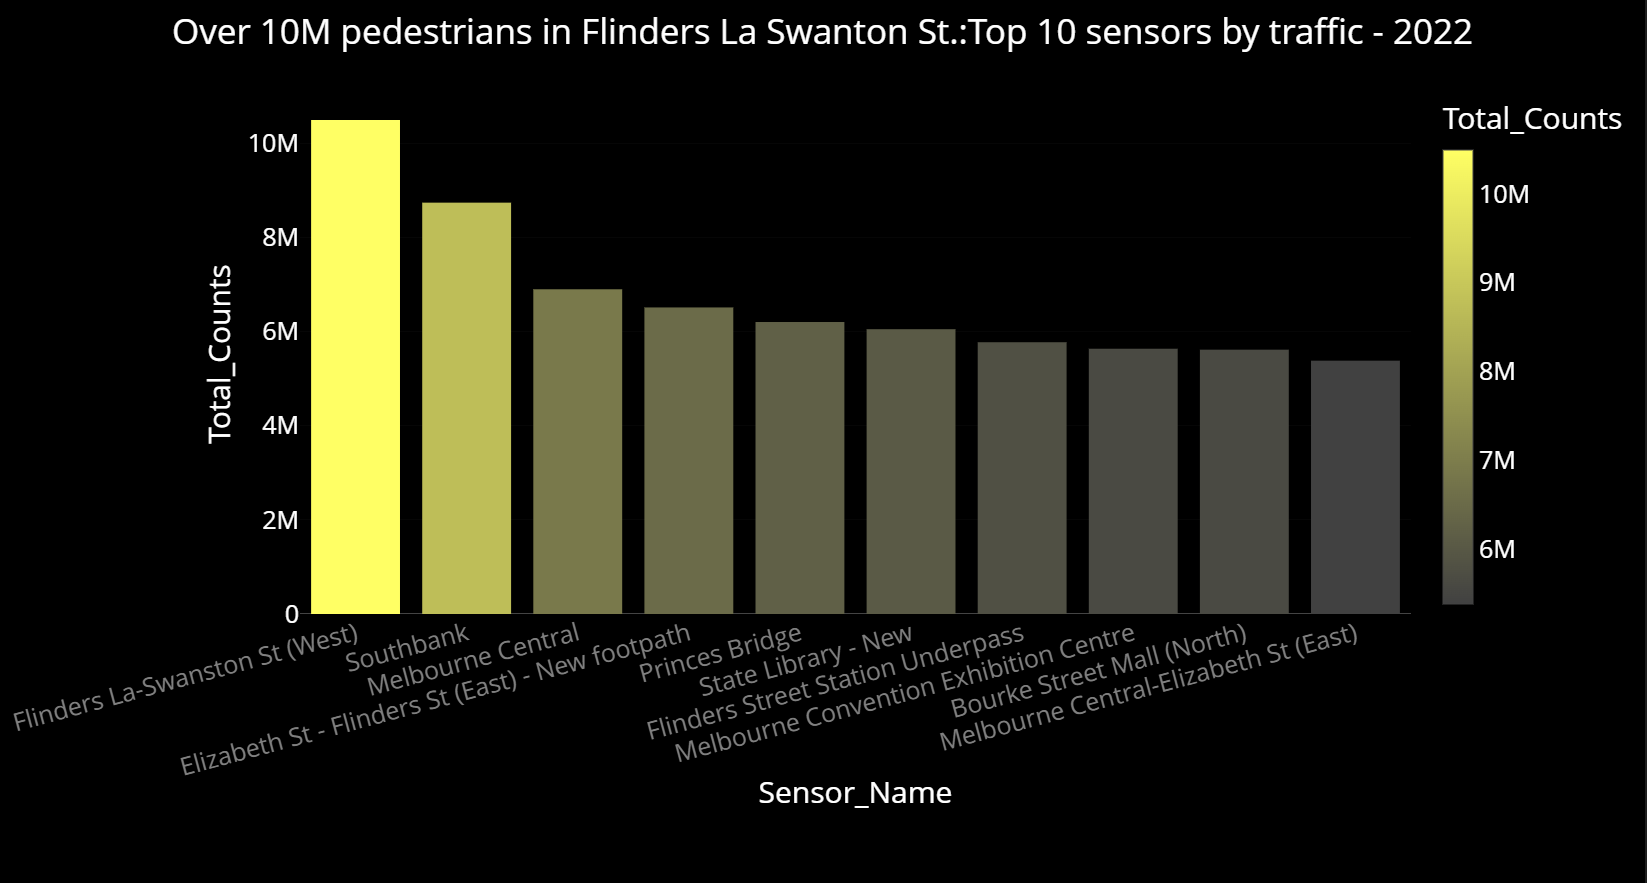


I **designed** this graphical configuration by **making decisions** about:
- the background color, 
- fonts size and color too, 
- that gradient applied to the bars
  - and how it fades, 
- the x labels colors too 
  - and how they are rotated. 

#### **Plotly Templates**:
In plotly, this whole graphical configuration (which is essentially the whole Plotly figure code itself) can be saved as a **template** and then very simply and quickly used for future figures.  
This keeps your graphs consistent. 

So I saved it as a template in the duckdb_shared_code.py file **as a function and imported it** in the import parag.  
This way this style is available throughout this notebook. 

#### **Line Plot**:
I now want to see: 
- number of active sensors
- accross each year
- in a line plot

So here are the steps:
- I call the SQL query first 
- and then I convert the variable holding it into a df 
- and then I plot it with Plotly


In [22]:
%%sql sensors_cnt_years <<                  
-- calling the SQL query:
select Year, count(distinct Sensor_Name) 
    as Total_Sensors
from pedestrian_counts
group by Year
order by Year

In [23]:
# converting to a df
df_sensors_cnt_years = var_to_df(sensors_cnt_years)
df_sensors_cnt_years.head(5)

,Year,Total_Sensors
0,2009,18
1,2010,18
2,2011,18
3,2012,18
4,2013,32


Ok, I can now plot it:

In [ ]:
# variables used for the annotation in the plot:
year = 2021
total_sensors = 81

figure = px.line(
    df_sensors_cnt_years,
    x="Year",
    y="Total_Sensors",
    markers=True,
    height=700,
    title="Increasing Numbers of Sensors until 2021 - Total Active Sensors by Year",
    line_shape='linear'
)

figure.update_traces(line=dict(color='white'))

figure.add_annotation(
    x=year,
    y=total_sensors,
    text=f"{year}:\n{total_sensors} sensors",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-20,
    font=dict(size=15, color="yellow")
)

figure.update_layout(
    xaxis=dict(
        title="Year",
        title_standoff=50,
        automargin=True  # Ensures Plotly adjusts space automatically
    ),
    yaxis=dict(
        title="Total Sensors",
        title_standoff=50,
        automargin=True  # Prevents overlap issues
    ),
    # Extra space for better visibility
    yaxis_showgrid=True,
    yaxis_gridcolor='rgb(45,45,45)'  # Almost Black
)

# Dynamically adjust the width based on the title length
figure.update_layout(
    width=len(figure.layout.title.text) * 20
)

figure.show()

Again, I am displaying the PNG of that graph below here:

Pic of that graph:  

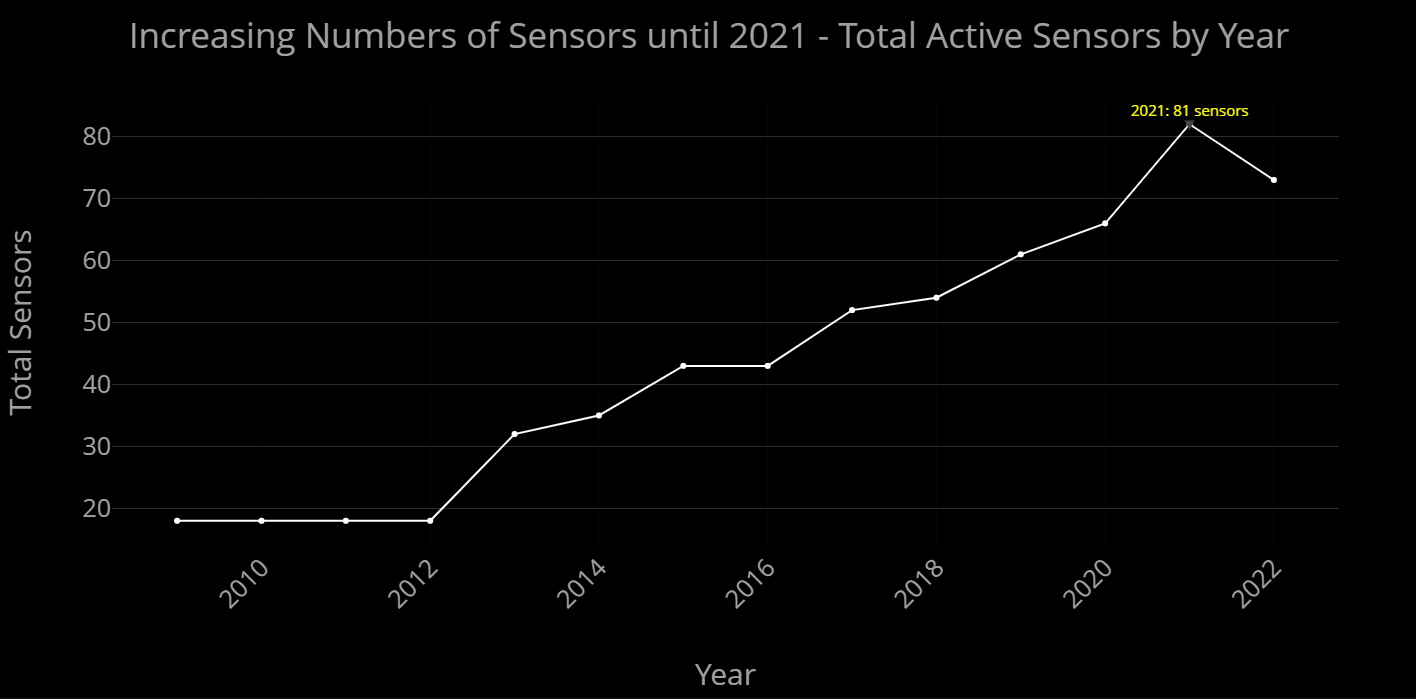

I used the Plotly **components** for the above graph to customize it: 
- added the graph horizontal lines (or **grid**) and made them a very dark grey
- **pushed** the axis titles away from the graph
- and added this **annotation** on the node of the 2021 year

This is following some of the **best practices** when it comes to visualizations.  
Noticed how I phrased the title? Instead of just saying what it is, I say **what is deducted** from it first.  
This way, the viewer knows right off the bat what this graph is about.

### **Total Pedestrian Counts over Time**: 

Continuing with this simple EDA and visualizations, I want to **better understand how**:
- the total number of pedestrians
- captured by all the sensors

has changed over time.

In [24]:
%%sql year_counts <<
select year, sum(Hourly_Counts)::BIGINT 
    as Total_counts
from pedestrian_counts
group by Year           -- getting sums for each distinct year
order by Year

In [25]:
df_year_counts = var_to_df(year_counts)
df_year_counts.head(5)

,Year,Total_counts
0,2009,62650110
1,2010,93459437
2,2011,90571965
3,2012,102215521
4,2013,117389820


Here's the Plotly Express code for a line plot of this new df:

In [ ]:
px.line(
    df_year_counts,
    x="Year",
    y="Total_counts",
    markers=True,
    height=500,
    title="Total Pedestrian Counts by Year"
)

Here's a pic of that graph:  

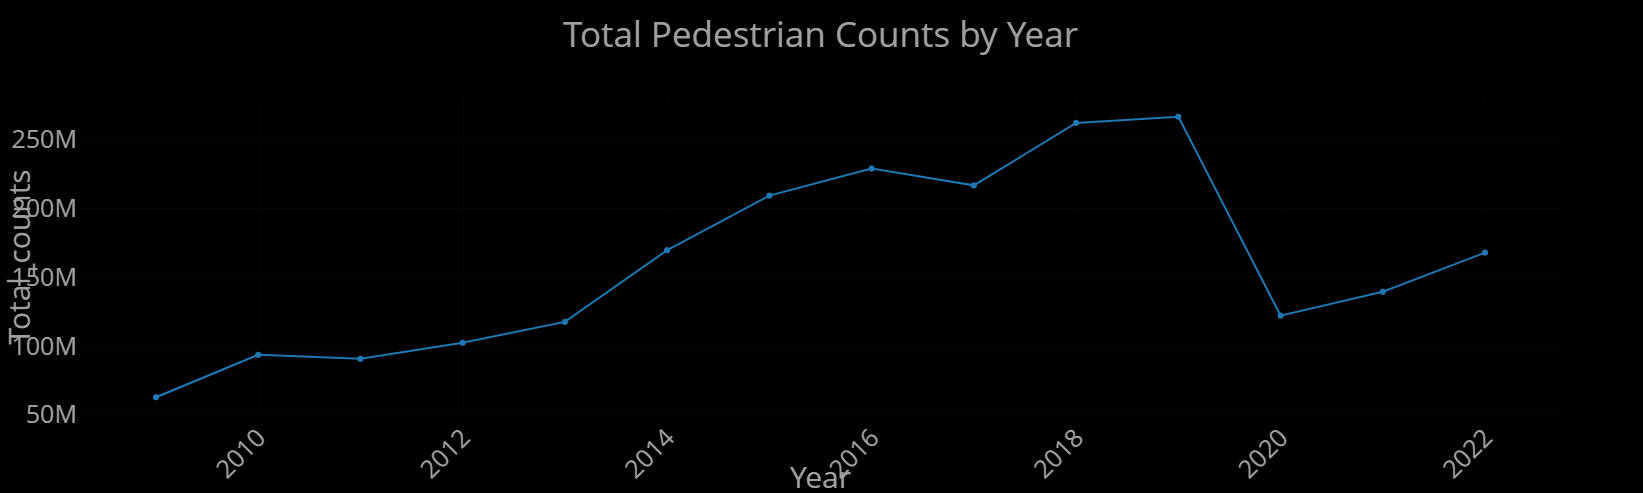

Let's fine tune this with Plotly components:

In [ ]:
# a function & variables used for the annotations:
year19 = 2019
year16 = 2016
year20 = 2020

def format_millions(value):
    return f"{value / 1_000_000:.2f}M"

# Plotly Express:
figure2 = px.line(
    df_year_counts,
    x="Year",
    y="Total_counts",
    markers=True,
    height=500,
    title="COVID-19 Drop in Total Pedestrian Counts by Year"
)

# Plotly Components:
figure2.update_traces(line=dict(color='white'))

# annotation for year 2019
figure2.add_annotation(
    x=year19,
    y=df_year_counts[df_year_counts['Year'] == year19]['Total_counts'].values[0],
    text=f"{year19}:   \n{format_millions(df_year_counts[df_year_counts['Year'] == year19]['Total_counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(size=15, color="yellow")
)

# annotation for year 2016
figure2.add_annotation(
    x=year16,
    y=df_year_counts[df_year_counts['Year'] == year16]['Total_counts'].values[0],
    text=f"{year16}:   \n{format_millions(df_year_counts[df_year_counts['Year'] == year16]['Total_counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-15,
    font=dict(size=15, color="yellow")
)

# annotation for year 2020
figure2.add_annotation(
    x=year20,
    y=df_year_counts[df_year_counts['Year'] == year20]['Total_counts'].values[0],
    text=f"{year20}:   \n{format_millions(df_year_counts[df_year_counts['Year'] == year20]['Total_counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=45,
    font=dict(size=15, color="yellow")
)

# pushing the titles away from the graph
figure2.update_layout(
    xaxis=dict(
        title="Year",
        title_standoff=50,
        automargin=True  # Ensures Plotly adjusts space automatically
    ),
    yaxis=dict(
        title="Total Records",
        title_standoff=50,
        automargin=True  # Prevents overlap issues
    ),
    # Extra space for better visibility
    yaxis_showgrid=True,
    yaxis_gridcolor='rgb(45,45,45)'  # Almost Black
)

# Dynamically adjust the width based on the title length
min_width = 1200
title_length_based_width = len(figure2.layout.title.text) * 20
figure2.update_layout(
    width=max(title_length_based_width, min_width),
    height=700,
    title_font_color="white",
)

figure2.show()

Here's a pic of that graph:  

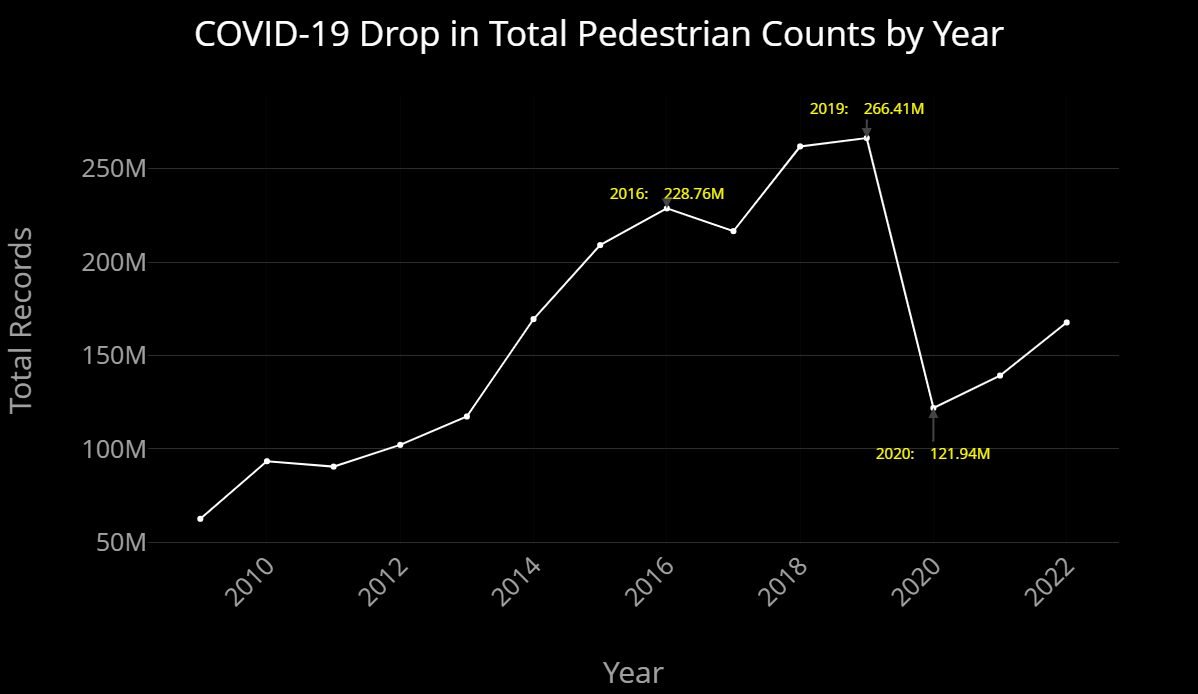

#### **Simple Analysis**:
2020 saw a dramatic drop, which coincides with the **2019 COVID-19 pandemic** and lock down. 
I also know that sensors were added over the years, and that is impacting the 2020 total records too.  

To know more **precisely** by how much that drop in 2020 was, I need to **filter out** all the sensors that **were added**.  
How?  
By selecting the **sensors that have records for all years**, because these sensors were there since the beginning and were not added later on. 

So first I need to know how many years are counted in the dataset. There are 14 distinct years. 
For my need here, this means that:
- each sensor that was there since the beginning (and so was not added later on) 
- has **exactly 14 captured values**, one for each year. 

I do not want any other sensor. 

In [26]:
%%sql distinct_years <<
select count(distinct Year)
from pedestrian_counts

In [27]:
print(f"\n{distinct_years}")


+------------------------+
| count(DISTINCT "Year") |
+------------------------+
|           14           |
+------------------------+


### **Specific Sensor_Name**:
It's best to capture these 14-years sensors' values into its own table:

In [28]:
%%sql
create or replace table sensors14years as       -- new table
select Sensor_Name
from pedestrian_counts
group by Sensor_Name                            -- getting only unique sensor names...
having count(distinct Year) = 14                -- ...that each has records on all 14 years 
;

Count


The `GROUP BY Sensor_Name`:   
The selected data is grouped by unique values in the "Sensor_Name" column. This means that **all rows with the same "Sensor_Name**" will be grouped together in that column.

- `HAVING COUNT(DISTINCT Year) = 14`:  
    The `HAVING` clause is used to filter the result of the grouping, which is the unique sensor names in the Sensor_Name column. From all these unique sensors, it's **looking for ones that do have a record for each of the 14 distinct "Year"**.  
If I used a WHERE clause instead, it would have looked at **ALL the rows** before grouping the relevant sensor names. 

Another query tells us there are **15 such sensors**. Their name is in the table `sensors14years` I just created in the previous code cell. 

In [29]:
%%sql 
select count(Sensor_Name)
from sensors14years

count(Sensor_Name)
15


Now that I know the sensors I need, I can use it to:
- filter out the total count of records
- and see how that 2020 year changes. 

In [30]:
%%sql year_counts_15sensors <<
select
    Year,
    sum(Hourly_Counts)::BIGINT as Total_Counts      -- sum of records converted to 64-bits integer
from pedestrian_counts
where Sensor_name in (from sensors14years)          -- ensuring to ONLY get sensors from sensors14years
group by Year                                       -- returning sum of records for each year
order by Year

In [31]:
# converting to a df:
df_year_counts_15sensors = var_to_df(year_counts_15sensors)
df_year_counts_15sensors.head(5)

,Year,Total_Counts
0,2009,50221628
1,2010,75078494
2,2011,71806437
3,2012,83356740
4,2013,81092589


#### **Updated Line Plot**:
And I am now back at the line plot, updating it with this new data based on the **relevant 15 sensors**:

In [ ]:
# variables used for the annotations:
year19 = 2019
year20 = 2020

figure2 = px.line(
    df_year_counts_15sensors,
    x="Year",
    y="Total_Counts",
    markers=True,
    height=500,
    title="Increasing Pedestrian Counts until Covid-19 - Total Pedestrian Counts by Year"
)

figure2.update_traces(line=dict(color='white'))

def format_millions(value):
    return f"{value / 1_000_000:.2f}M"

figure2.add_annotation(
    x=year19,
    y=df_year_counts_15sensors[df_year_counts['Year'] == year19]['Total_Counts'].values[0],
    text=f"{year19}:   \n{format_millions(df_year_counts_15sensors[df_year_counts_15sensors['Year'] == year19]['Total_Counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(size=15, color="yellow")
)

# annotation for year 2020
figure2.add_annotation(
    x=year20,
    y=df_year_counts_15sensors[df_year_counts_15sensors['Year'] == year20]['Total_Counts'].values[0],
    text=f"{year20}:   \n{format_millions(df_year_counts_15sensors[df_year_counts_15sensors['Year'] == year20]['Total_Counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=45,
    font=dict(size=15, color="yellow")
)

figure2.update_layout(
    xaxis=dict(
        title="Year",
        title_standoff=50,
        automargin=True  # Ensures Plotly adjusts space automatically
    ),
    yaxis=dict(
        title="Total Records",
        title_standoff=50,
        automargin=True  # Prevents overlap issues
    ),
    # Extra space for better visibility
    yaxis_showgrid=True,
    yaxis_gridcolor='rgb(45,45,45)'  # Almost Black
)

# Dynamically adjust the width based on the title length
min_width = 1200
title_length_based_width = len(figure2.layout.title.text) * 20
figure2.update_layout(
    width=max(title_length_based_width, min_width),
    height=700,
    title_font_color="white",
)

figure2.show()

Here's a pic of that graph:  

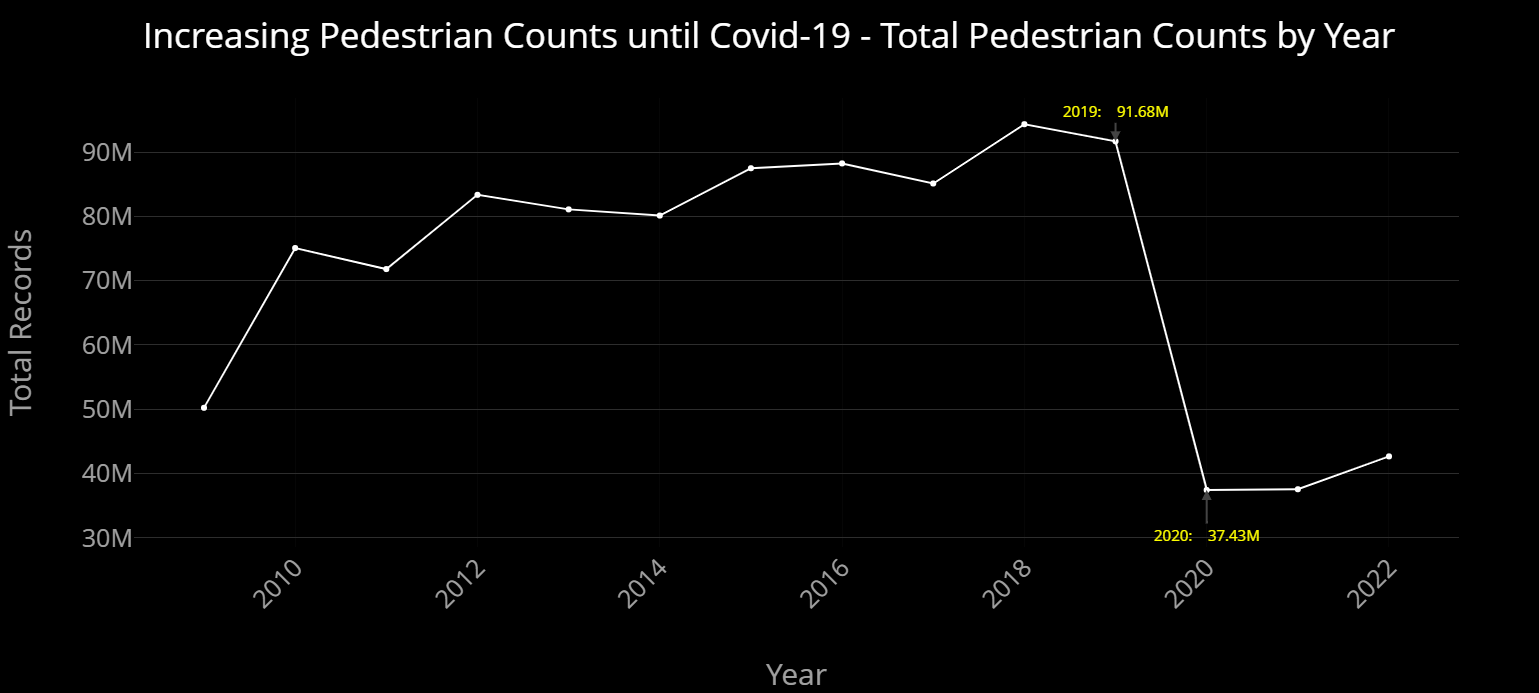

As expected. Because there are less sensors and most of all, **NO sensors added** over the years, the increase each year is diminished, and the COVID-19 drop is even more dramatic. 

### **Zoom in on 2019 to 202**1:
I now want to zoom in on these years 2019 to 2021 so that I can see **numbers per month**. 

I will extract the data accordingly from the `pedestrian_count` table. Here's what I need:
- years and months
- total counts for each
- from the 15 sensors (`df_year_counts_15sensors`)

In [32]:
%%sql yr_mths_counts <<
select
    Year,
    Month,                                          -- selecting the actual months...
    month(Date_Time) as Month_Num,                  -- ...adding the corresponding month number... 
    sum(Hourly_Counts)::BIGINT as Total_Counts
from pedestrian_counts
where Year in (2019, 2020, 2021)                    -- ...from these 3 years only...
    and Sensor_Name in (from sensors14years)        -- ...and these sensors only...
group by 
    Year, Month, Month_Num                          -- and returning Total_Counts for Year, Month
order by
    Year, Month_Num

Before I convert this to a df, note that the line 5:
- `month(Date_Time) as Month_Num,`
is adding the corresponding month number into a new column `Month_Num` by using a DuckDB function, `month()`. 

Also, I had to add it to the group by clause, however it is **not messing with the grouping** because Month_Num values are **coming from Month**.  
But if it wasn't, then yes, it would have been messing with the grouping. 

In [33]:
df_yrs_mths_counts = var_to_df(yr_mths_counts)
df_yrs_mths_counts.head(15)

,Year,Month,Month_Num,Total_Counts
0,2019,January,1,7000243
1,2019,February,2,6079776
2,2019,March,3,7740551
3,2019,April,4,8281383
4,2019,May,5,7908534
5,2019,June,6,7323166
6,2019,July,7,7915558
7,2019,August,8,8013224
8,2019,September,9,7436127
9,2019,October,10,7665717


#### **Multiple Lines with Plotly Traces**: 
This df is ready for plotting. I want to see each year plotted as **its own line**.  
In Plotly Express I can do that by referencing them as **traces** and other parameters of the plot. 

Note that I also chose to make the line in both a different **color** and a different **marker**, to make each line demarks itself better. 

In [ ]:
from plotly.subplots import make_subplots

# Create subplots: 1 row, 3 columns with reduced spacing
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=("2019", "2020", "2021"), horizontal_spacing=0.01)

# Add traces for each year
years = [2019, 2020, 2021]
symbols = ["square", "diamond", "circle"]
colors = ["#1F77B4", "#FF7F0E", "#2CA02C"]

for i, year in enumerate(years):
    df_year = df_yrs_mths_counts[df_yrs_mths_counts["Year"] == year]
    fig.add_trace(
        px.line(
            df_year,
            x="Month",
            y="Total_Counts",
            markers=True,
            symbol_sequence=[symbols[i]],
            color_discrete_sequence=[colors[i]]
        ).data[0],
        row=1, col=i+1
    )

# Update layout
fig.update_traces(marker=dict(size=12))  # Increase marker size

fig.update_layout(
    height=500,
    title="Post COVID-19: 2019, 2020, 2021 monthly Traffic - 15 original sensors",
    title_font_color="white",
    showlegend=False
)

fig.update_xaxes(title_text="Months", title_standoff=50, automargin=True, tickfont=dict(color='rgb(90,90,90)'))
fig.update_yaxes(title_text="Total Records", title_standoff=50, automargin=True, gridcolor='rgb(45,45,45)', range=[0, 10_000_000])

# Remove y-axis title for the 2nd and 3rd subplots
fig.update_yaxes(title_text=None, row=1, col=2)
fig.update_yaxes(title_text=None, row=1, col=3)

fig.show()


Here's a pic of that graph:  

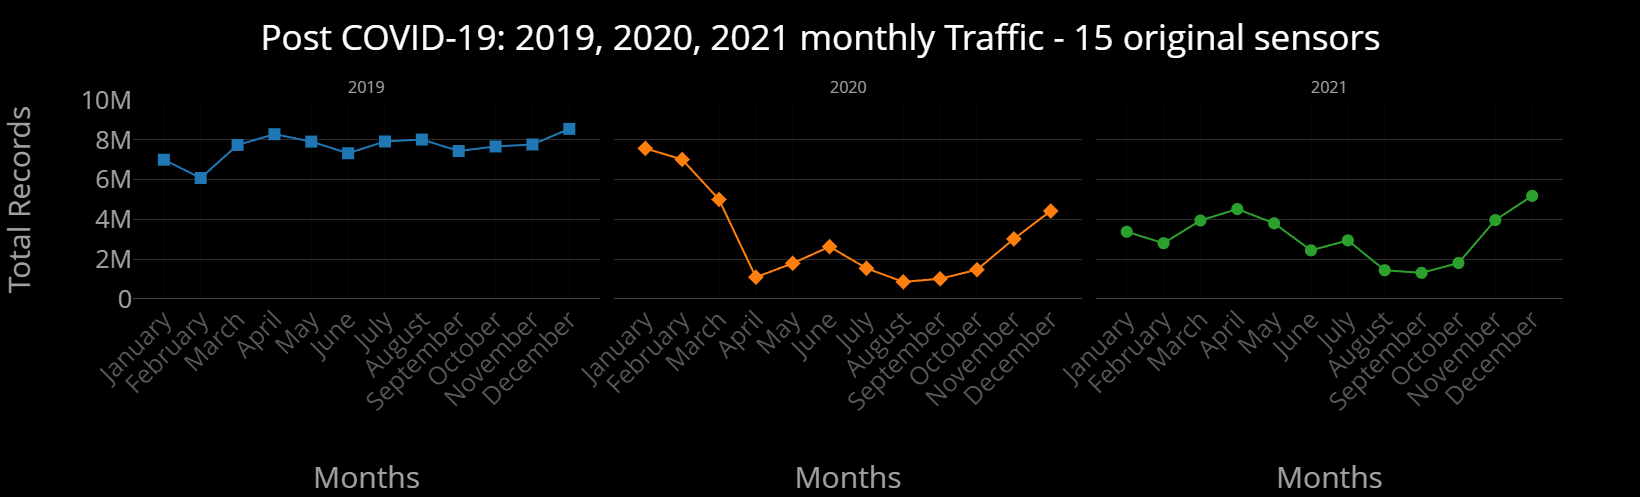

For **continuity** I chose to plot these 3 years **side by side**, clearly showing the decline progressing from 2019.  
Keep in mind that the data was applying the df with ONLY the 15 original sensors (no new ones added), giving us more refined counts. 


### **Zoom in on Hours data**:

As I zoomed in into the months of these 3 years, I now want to look at:
- hours 
- of specific sensors

This Flinders La-Swanston St (West) sensor is the one that collected the highest number of records (go back to the [plot here](#plotly)).  
So I want to look at it first.


In [34]:
%%sql sensors_2020 <<
select 
    Hourly_Counts, 
    Date_Time
from pedestrian_counts
where Sensor_Name = 'Flinders La-Swanston St (West)' and Year = 2020 

In [35]:
sensors_2020_df = var_to_df(sensors_2020)
sensors_2020_df.head(5)

,Hourly_Counts,Date_Time
0,3889,2020-01-01 00:00:00
1,3950,2020-01-01 01:00:00
2,2681,2020-01-01 02:00:00
3,1572,2020-01-01 03:00:00
4,728,2020-01-01 04:00:00


In [ ]:
# Plotting a line graph of the new df:
figure = px.line(
    sensors_2020_df,
    y="Hourly_Counts",
    x="Date_Time",
    markers=True,
    height=500,
    width=500,
    title="Drop in Hourly Traffic for Flinders La-Swanton during COVID-19 2020"
)

figure.update_traces(line=dict(color='rgb(184, 115, 51)'))

figure.update_layout(
    xaxis=dict(
        title="Each single day of 2020",
        title_standoff=50,
        automargin=True  # Ensures Plotly adjusts space automatically
    ),
    yaxis=dict(
        title="Hourly Records",
        title_standoff=50,
        automargin=True  # Prevents overlap issues
    ),
    # Extra space for better visibility
    yaxis_showgrid=True,
    yaxis_gridcolor='rgb(45,45,45)'  # Almost Black
)

# Dynamically adjust the width based on the title length
min_width = 1700
title_length_based_width = len(figure.layout.title.text) * 20
figure.update_layout(
    width=max(title_length_based_width, min_width),
    height=700,
    title_font_color="white",
)

figure.show()

Here's a pic of that graph:  

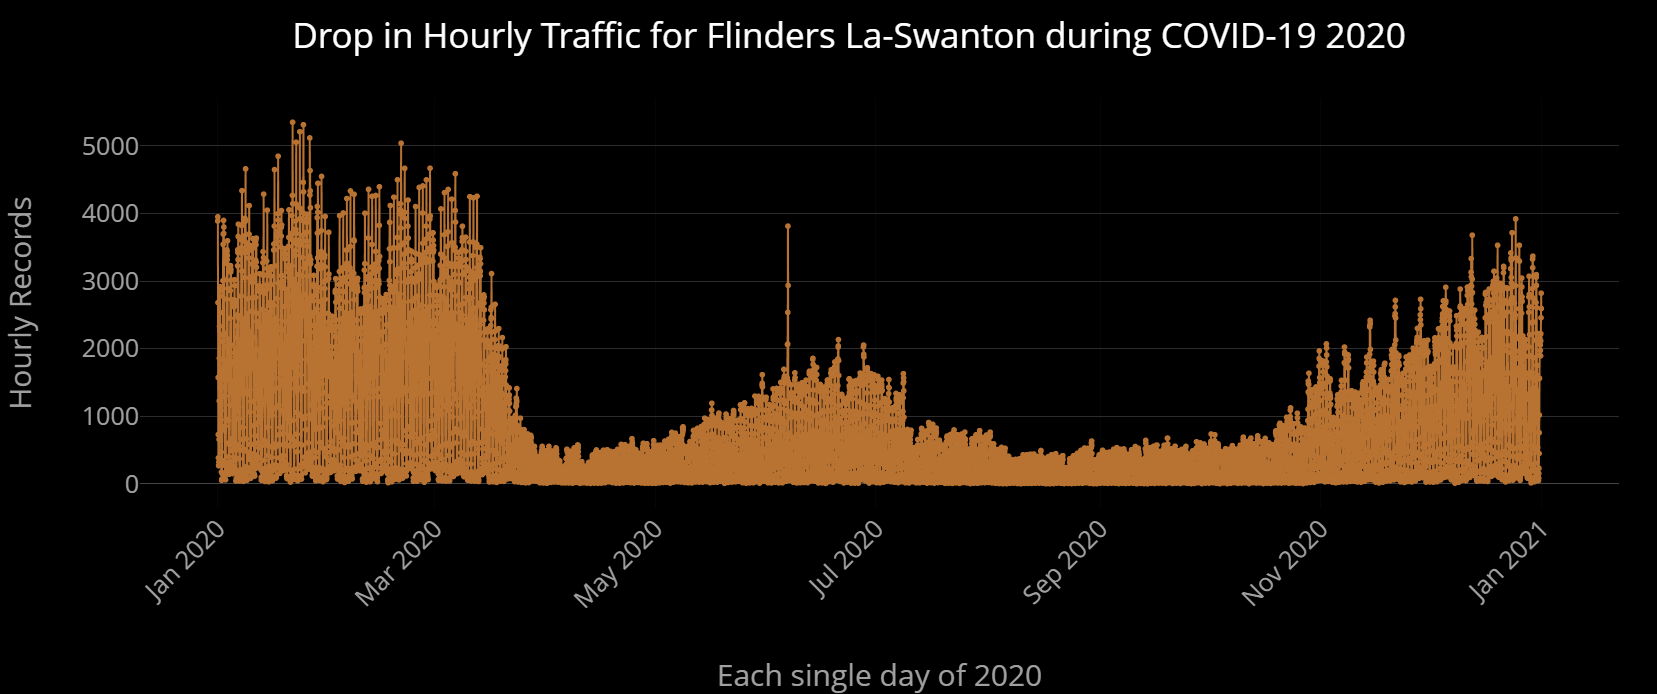

This graph shows how the traffic evolved in **2020 at the hour detail**.  

Essentially we see:
- **three** drops, 
  - each corresponding to the first **2 lockdowns**:
    - March 31, July 7
Similarly, lift-offs are corresponding to when lockdowns ended:
    - mid-May and October

See that peak on June 6?  
It is coinciding with a Black Lives Matter protest that occurred close to the central business district.



#### **Interactive Plot**:

As mentioned before, Plotly is **interactive**, this means that with my mouse cursor I can **click and select** an area of the plot above, say an area that frames that June 6th day. This will limit the graph to that **selection**, showing me numbers related to days that are included in the area I chose. Try it now! 

What is striking is that **each day** does not appear as one vertical stick but more like a a row of **wavelengths**, very similar to frequency waves.  
Essentially, each wave represents the **daily rhythm of people's activity**.  

On the 6th of June, if I hover over its points, I can see that starting at 12pm (which seems to be the average peak of most other days, and **thinking this way is actually wrong**, more below), the traffic kept increasing, reaching almost 4,000 counts at 4pm.  

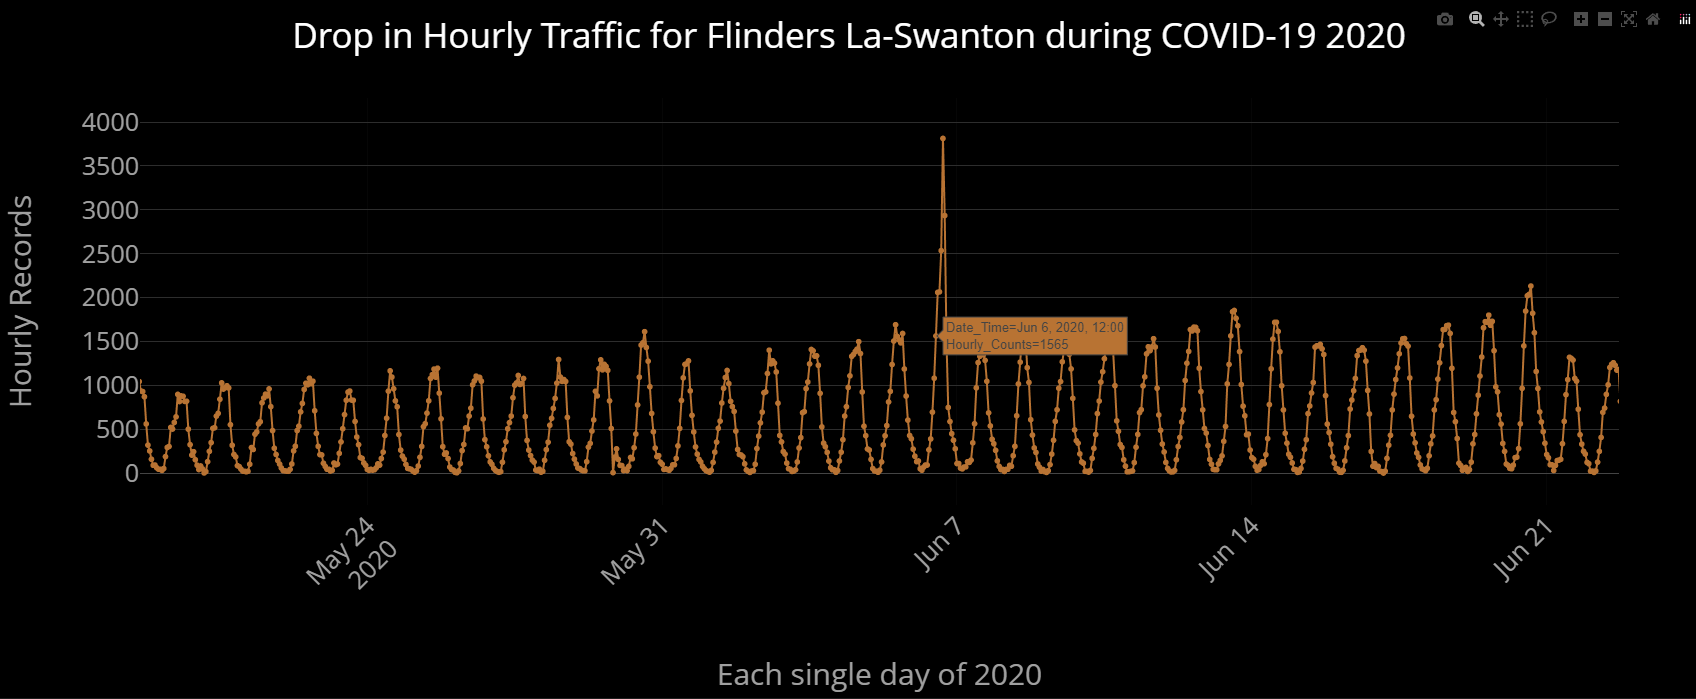

#### **Zooming in for more details**:
And if I select a range of two days before and after June 6, I see even more details:  

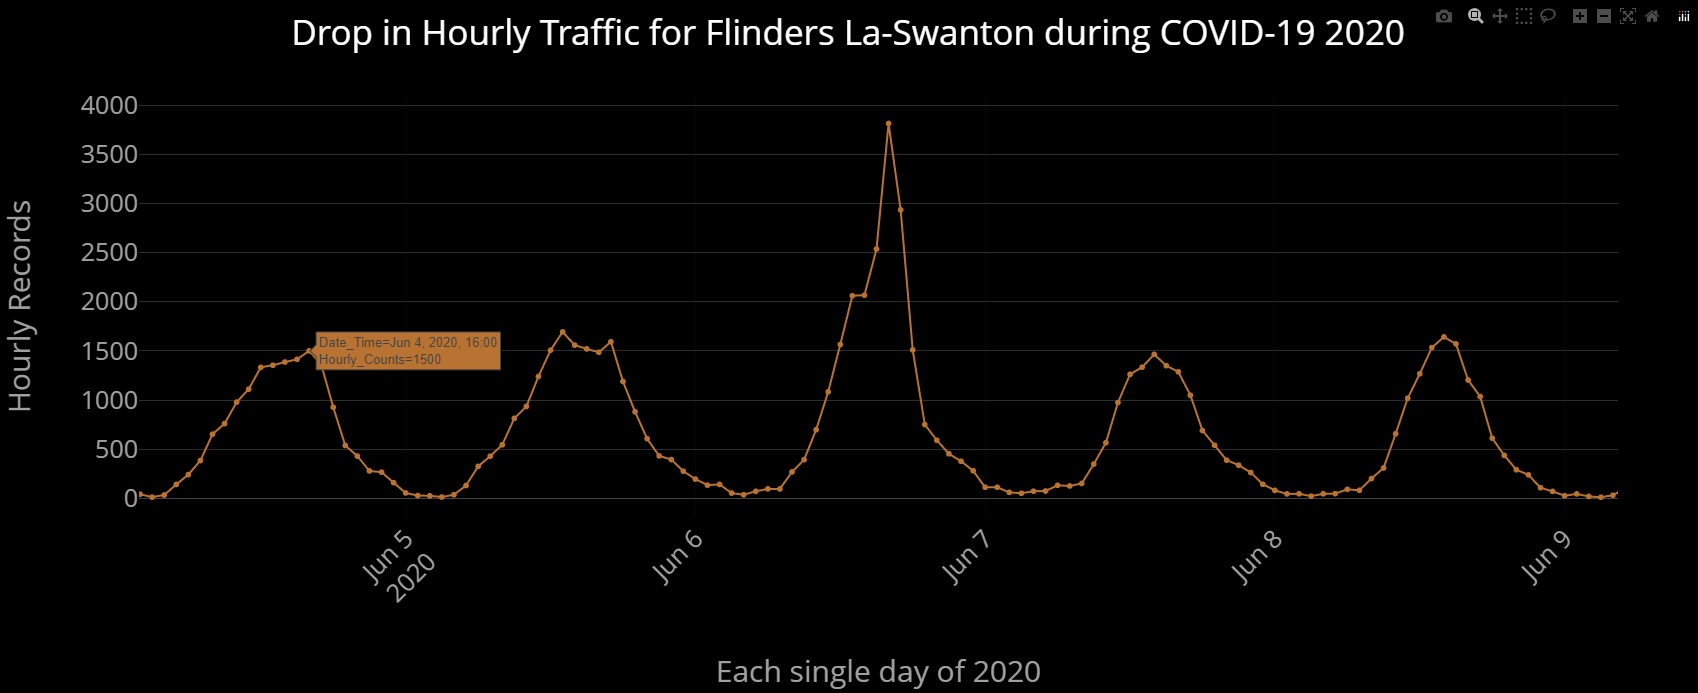

Now I clearly see a 1pm break on June 6, and except for June 4, the **peak of each day is actually between 1 and 2pm**.  
This last observation reminds me that the peaks are not on an hour scale (the **y axis is Hourly Records**, **NOT Hour of the day**), and I should not make the mistake of thinking so. These peaks are **hourly traffic peaks**, and so each peak may be on a different hour, as it is obviously for June 6.

### **Comparing Data Patterns**:

Now my chain of thought leads me to see if **other sensors have this same pattern** of daily rhythm.  

So what I want is:
- to **compare them** and see if there are differences between, say 3 sensors, 
  - for the month of September 
  - year 2019

In [36]:
%%sql three_sensors_sept2019 <<
select 
    Sensor_Name, 
    Hourly_COunts,
    Date_Time
from pedestrian_counts
where Sensor_Name in (                  -- tuple of the 3 sensors names
    'Flinders St-Spark La',
    'Bourke Street Mall (North)',
    'Southern Cross Station',
) and                                   -- filtering down to September 2019
    Year = 2019 and Month = 'September'

In [37]:
df_three_sensors_sept2019 = var_to_df(three_sensors_sept2019)
df_three_sensors_sept2019.Sensor_Name.value_counts()

Sensor_Name
Flinders St-Spark La          720
Bourke Street Mall (North)    720
Southern Cross Station        720
Name: count, dtype: int64

In [ ]:
figure = px.line(
    df_three_sensors_sept2019,
    y="Hourly_Counts",
    x='Date_Time',
    facet_col="Sensor_Name",
    facet_col_wrap=1,
    title="Distinct Hourly Traffic Patterns of 3 sensors in Sept. 2019 COVID-19",
    height=800,
).update_layout(yaxis_fixedrange=True)

figure.update_traces(line=dict(color='rgb(184, 115, 51)'))

# Dynamically adjust the width based on the title length
min_width = 1200
title_length_based_width = len(figure.layout.title.text) * 20
figure.update_layout(
    width=max(title_length_based_width, min_width),
    title_font_color="rgb(200, 200, 200)",
    height=700
)

# Add horizontal padding and change y-axis label titles
figure.update_yaxes(title_text='Hrly Rec.', automargin=True, title_standoff=60)
figure.update_xaxes(automargin=True, title_standoff=40)
figure.layout.xaxis.title.text = 'Each Day of Sept. 2019'

figure.show()

Here's the pic of that graph:  

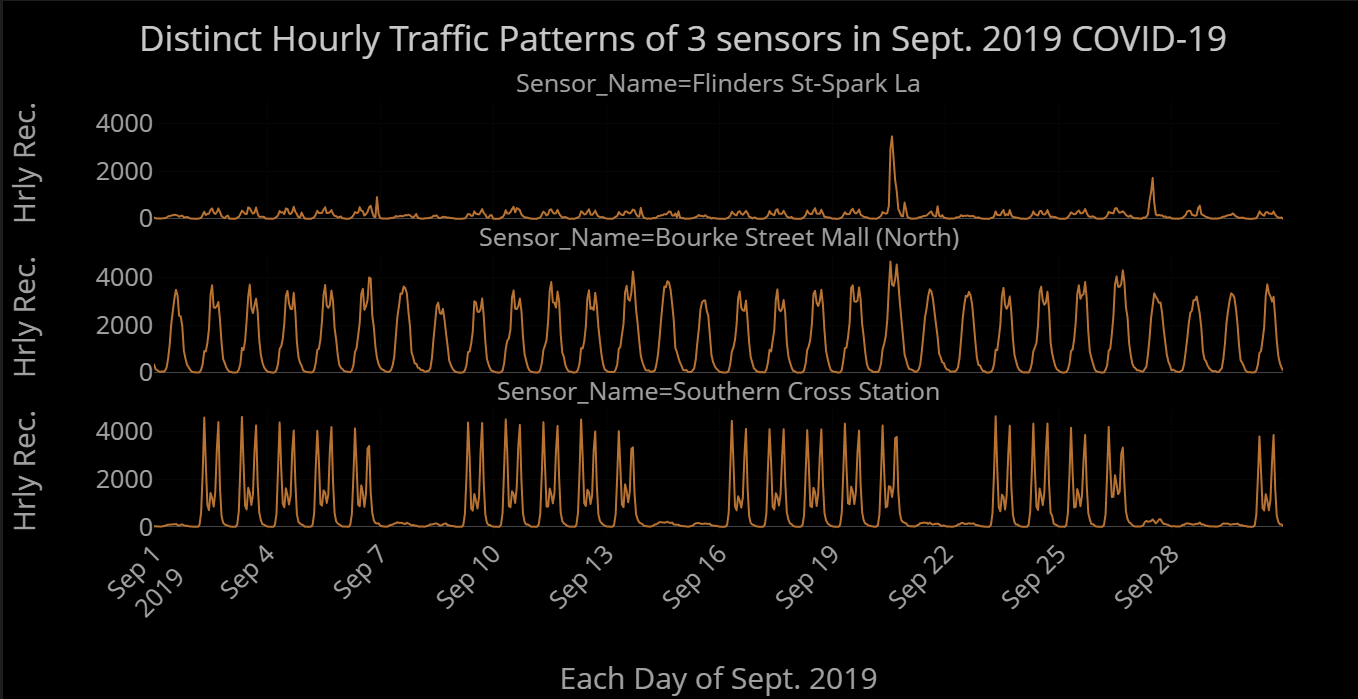

The three patterns returned by the plot are strikingly different: 
- Southern Cross Station being a **major transportation hub**, this pattern represents **people commuting for work**, hence these flat weekend segments and the contrast of high week days traffic versus low weekend traffic.
- Flinders on the contrary is located at the **fringe of the CBD** and so sees significantly less traffic.  
  That peak on Sept. 20 is due to a strike that happened that day in its vicinity.
- Bourke Street Mall is located at a **mall**, and as such it attracts people a **lot more regularly**, with no discernable differences between weed days and weekends, except for a recurring peak on Fridays. 

#### **Importance of fixed range**: 
When **comparing** data from the **same source**, here sensors, we do not want the range of the axis to change for each subplot (here called facets).  
This is why I used this line when I first declared my figure (line 9):  
- `.update_layout(yaxis_fixedrange=True)` 

And this line gives the **same range** for the y axis, and now I can **more accurately compare** apple to apple.  


### **Distribution Plots**: 

I just looked at very pinpointed values from specific sources and over a specific time frame. Time series are great for that.  
I now want to dig deeper and look at the distribution of some aggregations, say:
- the total of hourly counts 
  - for each day
- from one sensor (Bourke)
- for each year from 2019-21 (so three years = 3 distributions)

Let's extract all of that:

In [38]:
%%sql bourke_dayly_19to21 <<
select
    Year,
    Date_Time::DATE as Date,                        -- formatting date into a new col Date
    sum(Hourly_Counts)::BIGINT as Daily_Counts,
from pedestrian_counts
where Sensor_Name = 'Bourke Street Mall (North)'
    and Year in (2019, 2020, 2021)
group by Year, Date                                 -- sum for each day and each year

In [39]:
df_bourke_dayly_19to21 = var_to_df(bourke_dayly_19to21)
df_bourke_dayly_19to21.head(10)

,Year,Date,Daily_Counts
0,2019,2019-02-25,32500
1,2019,2019-02-26,30956
2,2019,2019-03-09,37106
3,2021,2021-03-29,14629
4,2021,2021-04-09,23457
5,2019,2019-01-04,22161
6,2019,2019-01-10,31016
7,2019,2019-01-13,27226
8,2019,2019-01-23,32410
9,2019,2019-02-01,36099


In [ ]:
# Plotting the box plot: 
figure = px.box(
    df_bourke_dayly_19to21,
    x='Year',
    y='Daily_Counts',
    points='all',
    height=600,
    title='Distribution of Daily Traffic for sensor Bourke St. Mall in Years 2019 to 2021',
)

# Dynamically adjust the width based on the title length
min_width = 1200
title_length_based_width = len(figure.layout.title.text) * 20
figure.update_layout(
    width=max(title_length_based_width, min_width),
    title_font_color="rgb(200, 200, 200)",
    height=700
)

# Add horizontal padding and change y-axis label titles
figure.update_yaxes(title_text='Total Hourly Count per Day', automargin=True, title_standoff=60)
figure.update_xaxes(automargin=True, title_standoff=40)
figure.layout.xaxis.title.text = 'Selected Years'

figure.show()

Here's the pic of that graph:  
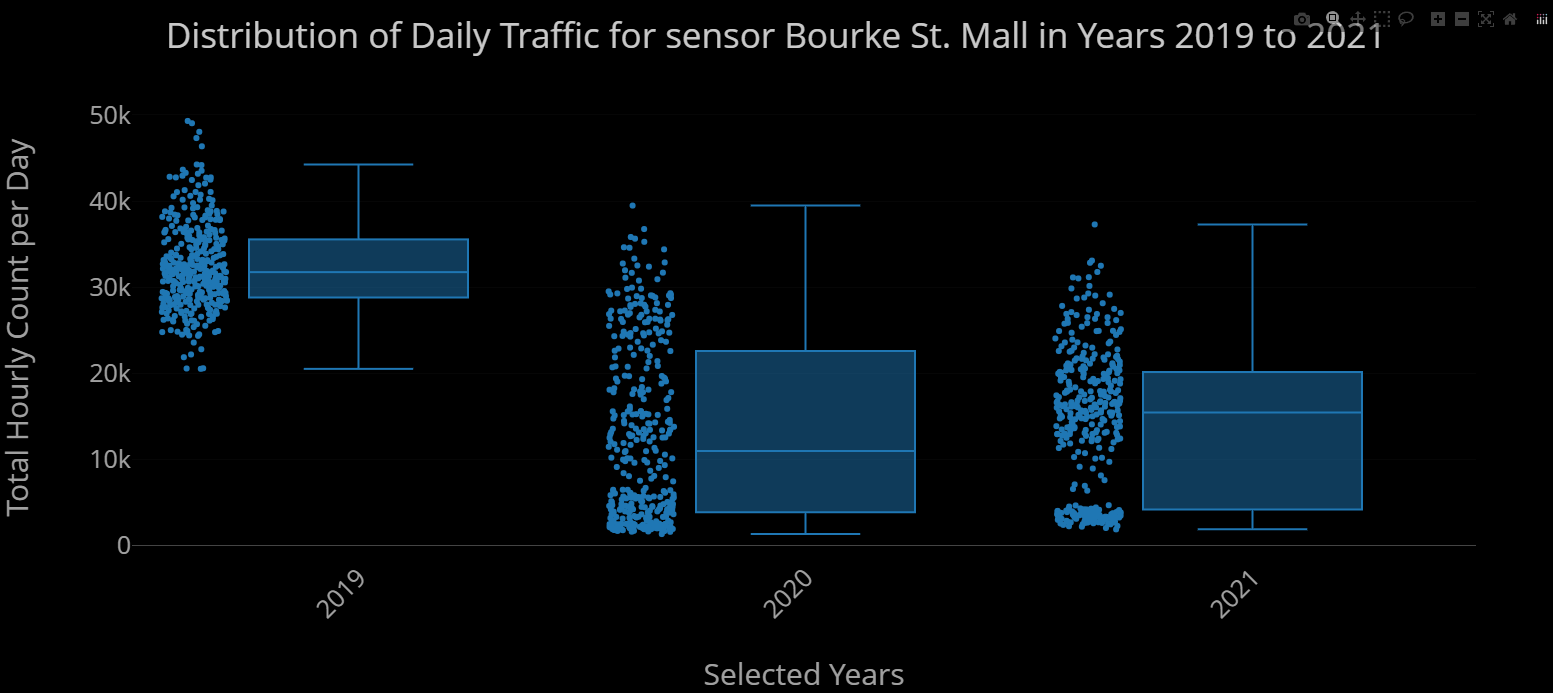

I clearly see that the 2019 box is higher than the 2 others, giving a minimum daily count of about 20K while the **others are very close to 0**.  
Though, the max from each box is not as different, ranging from 40 to 45K for all of them, however the dots tell me that for 2020 and 21 this is rather a **more isolated max value**.  
Even clearer is that **shift of the first three quartiles** to the bottom, lowering the 3rd quartile top from ~37K to ~20K.

### **Histogram Distribution Plots**:

Additionally it is good to see these distribution layed out as histograms and stacked, giving me **both variables**, one on each axis.  
This histogram version is **more readable for most non-data people** who most of them struggles reading a box plot (let alone 3 of them together).

In [ ]:
# Create subplots: 3 rows, 1 column with reduced spacing
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("2019", "2020", "2021"), vertical_spacing=0.15)

# Add traces for each year
years = [2019, 2020, 2021]
colors = ['#2CA02C', '#1F77B4', '#FF7F0E']

for i, year in enumerate(years):
    df_year = df_bourke_dayly_19to21[df_bourke_dayly_19to21["Year"] == year]
    fig.add_trace(
        px.histogram(
            df_year,
            x='Daily_Counts',
            color_discrete_sequence=[colors[i]],
            barmode='overlay',
            height=850
        ).data[0],
        row=i+1, col=1
    )

# Update layout
fig.update_traces(marker=dict(opacity=0.5))  # Set marker opacity

fig.update_layout(
    height=900,
    title="Distribution of Daily Traffic for sensor Bourke St. Mall in Years 2019 to 2021",
    title_font_color="rgb(200, 200, 200)",
    showlegend=False
)

fig.update_xaxes(title_text='Total Hourly Count per Day', title_standoff=40, automargin=True, fixedrange=True)
fig.update_yaxes(title_text='Count', title_standoff=60, automargin=True, fixedrange=True, gridcolor='rgb(45,45,45)')

# Remove x-axis title for the 1st and 2nd subplots
fig.update_xaxes(title_text=None, row=1, col=1)
fig.update_xaxes(title_text=None, row=2, col=1)

fig.show()

Here's a picture of that graph:  

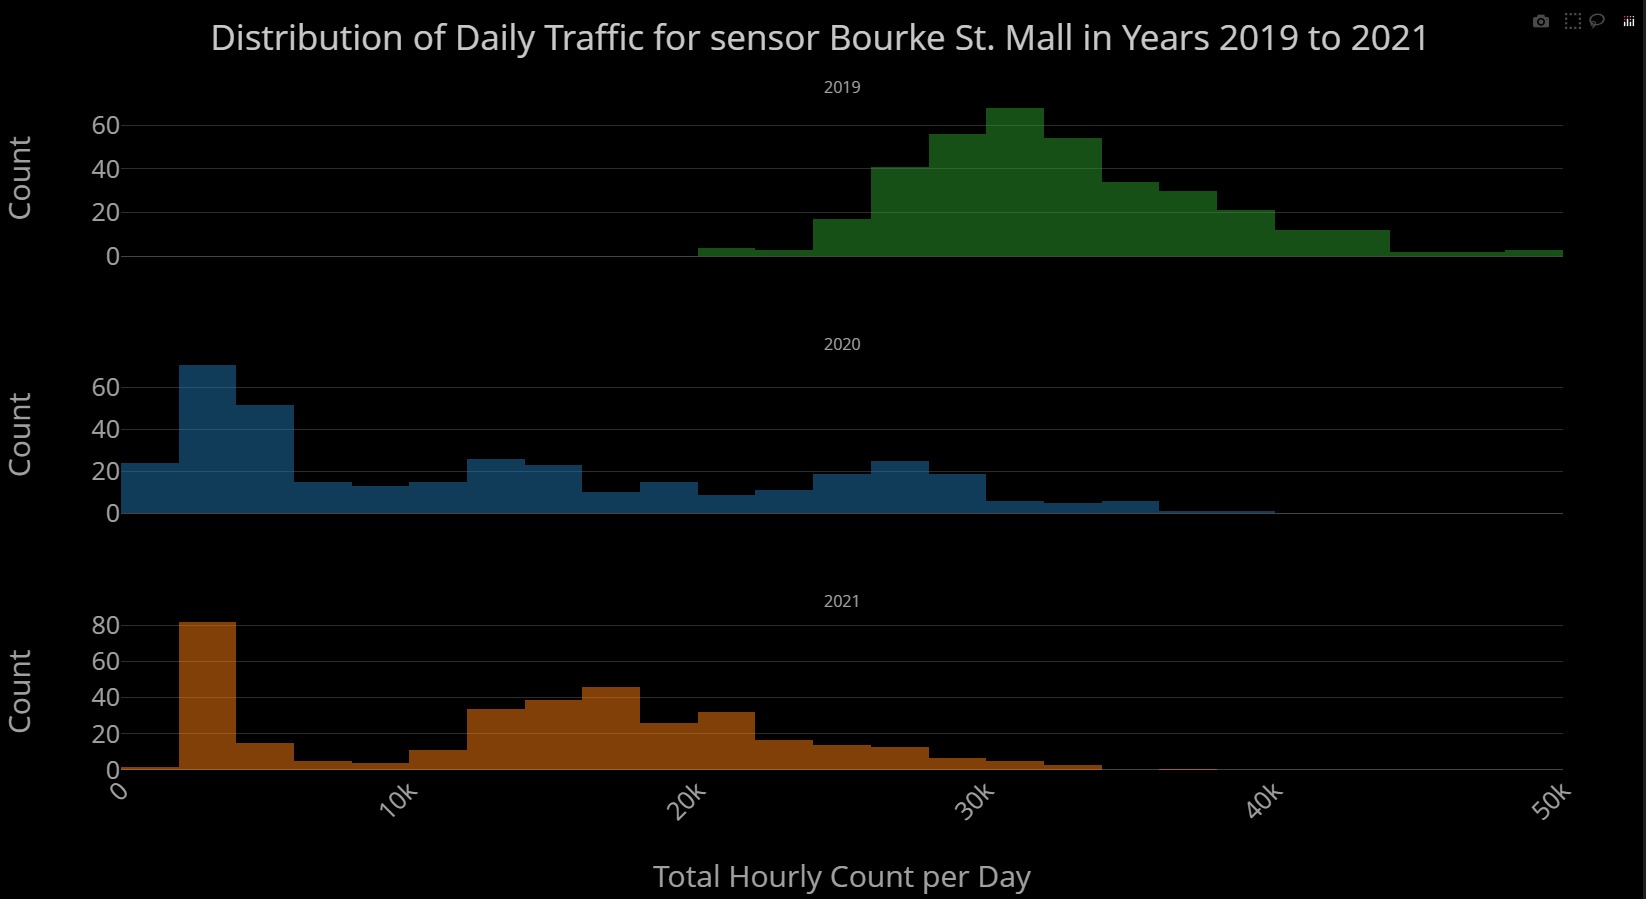

I can see it even clearer now, for:
- 2019: most of the counts are centered around that high 32K bar
- 2020: a big portion of the count is around that highest 4K bar, with a spread in the tail
- 2021: similar to 2020, the spread is a little thicker and centered around 18K

While the **box** plots gave a good look at the **proportions and min/max values**, the **histogram** plots really give me a better view on **how the data is actually distributed.**

---
